Project 4: Time series

Student name: Farnaz Golnam

Full time: online 120919

Instructor: Rafael Carrasco

Blog post URL: https://datasciencefordesigners.wordpress.com/2020/04/20/ai-and-deep-learning-applications-in-fashion-industry/

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [28]:
# Importing necessary libraries:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from matplotlib import rc
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

import itertools

import warnings
warnings.filterwarnings('ignore')

##########################
# turning the wide dataframe to long version:
def melt_data_new(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 
                                  'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True, format='%Y-%m-%d')
    melted = melted.dropna(subset=['value'])
    #return melted.groupby('time').aggregate({'value':'mean'})
    melted.set_index(keys='time', inplace=True)
    return melted

###########################
#Importing the original dataset
data=pd.read_csv('./zillow_data.csv')

###########################
#separate out the Metro areas of San Jose, wide_format
data_sj = data[(data.Metro == 'San Jose') & (data.State == 'CA')]
#print(data_sj.City.unique())
#print(data_sj.shape)

###########################
# Converting the wide_format dataset to the long_format
data_sj=melt_data_new(data_sj)
#print(data_sj.head())

###########################
# we generate a model based on zip code 95051 time-series, and use it for the other zip codes
#zip_df = data_sj.loc[(data_sj.RegionName==95051), ['value']].resample('MS').mean()
zip95051_df = data_sj.loc[(data_sj.RegionName==95051), ['value']]
#print(zip95051_df.size)

In [29]:
# our data set
data_sj.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,97991,95123,San Jose,CA,San Jose,Santa Clara,245,224500.0
1996-04-01,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0
1996-04-01,97940,95035,Milpitas,CA,San Jose,Santa Clara,364,231100.0
1996-04-01,97926,95014,Cupertino,CA,San Jose,Santa Clara,462,432400.0
1996-04-01,97980,95112,San Jose,CA,San Jose,Santa Clara,514,186800.0


# Step 2:data pre-processing for missing data, place holders and data types:

In [31]:
# data preprocessing:

#1.check for dataframe general information
print(data_sj.info(),'\n')

##########################################
#2.check for missing data
print(data_sj.isna().sum())

##########################################

#3.check for placeholders
#for column in data_sj:
    #Select column contents by column name using [] operator
    #columnSeriesdf = data_sj[column]
    #print('Colunm Name : ', column)
    #print('Column Contents : ', columnSeriesdf.unique())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14575 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      14575 non-null int64
RegionName    14575 non-null int64
City          14575 non-null object
State         14575 non-null object
Metro         14575 non-null object
CountyName    14575 non-null object
SizeRank      14575 non-null int64
value         14575 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.0+ MB
None 

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
value         0
dtype: int64


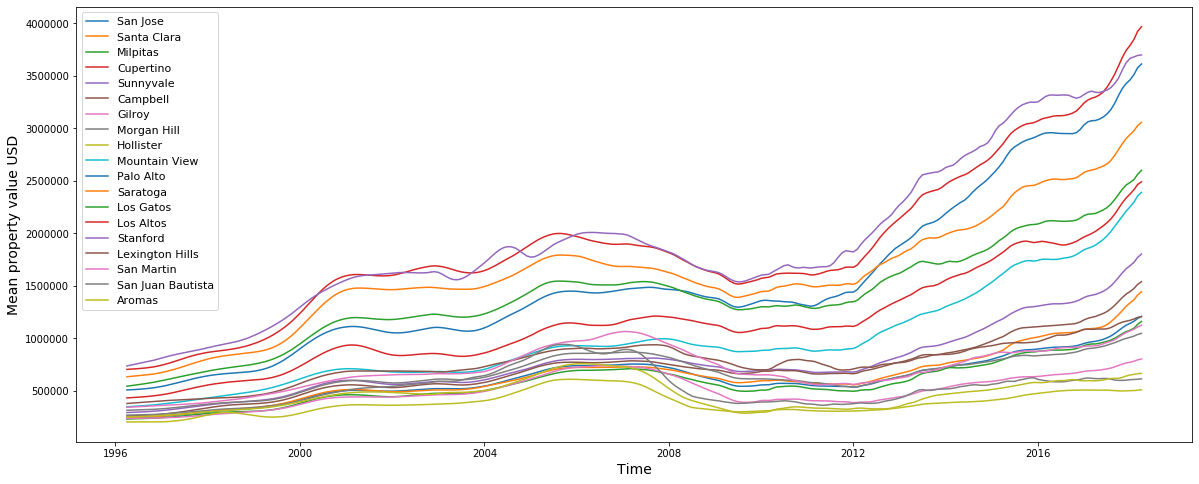

In [47]:
# Visualizing General Trend of property value in San Jose metro area:
plt.figure(figsize=(20,8))

for city in data_sj.City.unique():
    # Create a new DataFrame for cities in San Jose are and store their monthly mean values in columns
    city_df = data_sj.loc[(data_sj.City==city), ['value']].resample('MS').mean()  
    plt.plot(city_df, label=city)
    
plt.legend(prop={'size': 11})
plt.xlabel("Time",fontsize = 14)
plt.ylabel("Mean property value USD", fontsize = 14)
plt.show()

In [48]:
# our time series
zip95051_df.head()

,value
time,
1996-04-01,258700.0
1996-05-01,259300.0
1996-06-01,259900.0
1996-07-01,260500.0
1996-08-01,261100.0


# Step 3: checking timeseries stationarity and its ACF, PACF plots:

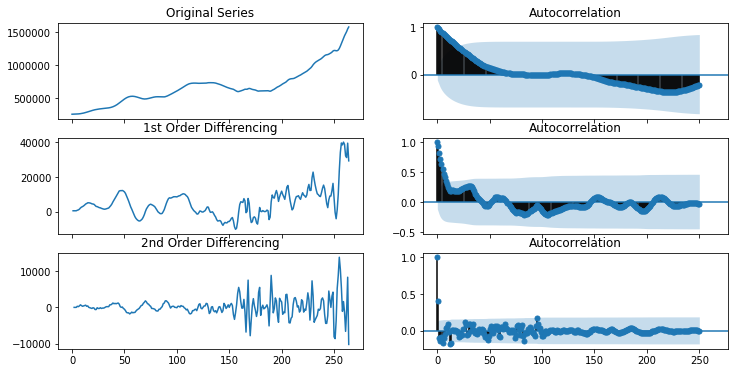

In [167]:
# Original Series
#.to_datetime
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12,6))
axes[0, 0].plot(zip95051_df.values); axes[0, 0].set_title('Original Series')
plot_acf(zip95051_df.values, ax=axes[0, 1], lags=250)

# 1st Differencing
zip95051_df_diff = zip95051_df.diff(periods=1)
axes[1, 0].plot(zip95051_df_diff.values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(zip95051_df_diff.dropna().values, ax=axes[1, 1], lags=250)

# 2nd Differencing
zip95051_df_diff2 = zip95051_df_diff.diff(periods=1)
axes[2, 0].plot(zip95051_df_diff2.values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(zip95051_df_diff2.dropna().values, ax=axes[2, 1], lags=250)

plt.show()

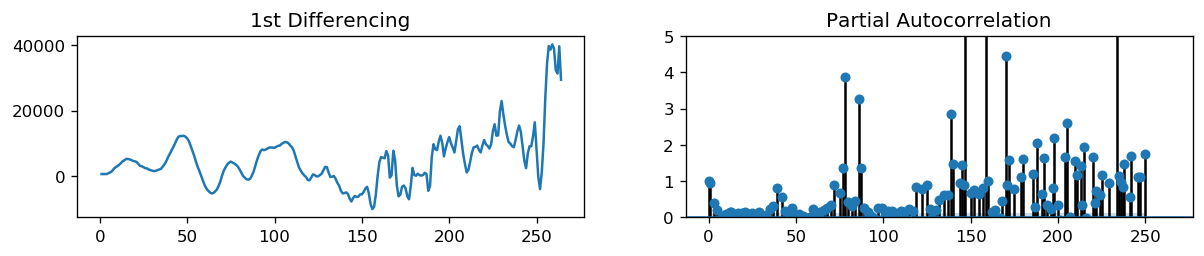

In [168]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(zip95051_df_diff.values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(zip95051_df_diff.dropna().values, ax=axes[1], lags=250)

plt.show()

# Step 4: searching for best model parameters:

In [169]:
# Import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#we had two differencing process so our d=2
p=range(0, 5)
d=range(1, 3)
q=range(0, 5)

#train = zip95051_df[:183]
#test = zip95051_df[183:]
#print(len(test))

#print(train)
train = zip95051_df.loc['1996-06-01':'2016-01-01']
test = zip95051_df.loc['2016-01-01':]

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
best_score, best_cfg = float("inf"), None

for i in pdq:
    try:
        # Fit an ARIMA model
        #print('ARIMA {}:'.format(i))
        model = ARIMA(train.values, order=i)
        model_fit = model.fit(disp=0)
        
        fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% conf
        
        # Make as pandas series
        fc_series = pd.Series(fc, index=test.index)
        mse = mean_squared_error(test.values, fc_series)
        
        if mse < best_score:
            best_score, best_cfg = mse, i
                
        #if model_fit.aic<aic_min:
        #    aic_min = model_fit.aic
        #    pdq_final = i
    except:
        continue
            
print(best_cfg)
print(best_score)


(4, 2, 4)
4639499341.066888


# Step 5: building the ARIMA model based on best selected parameters:

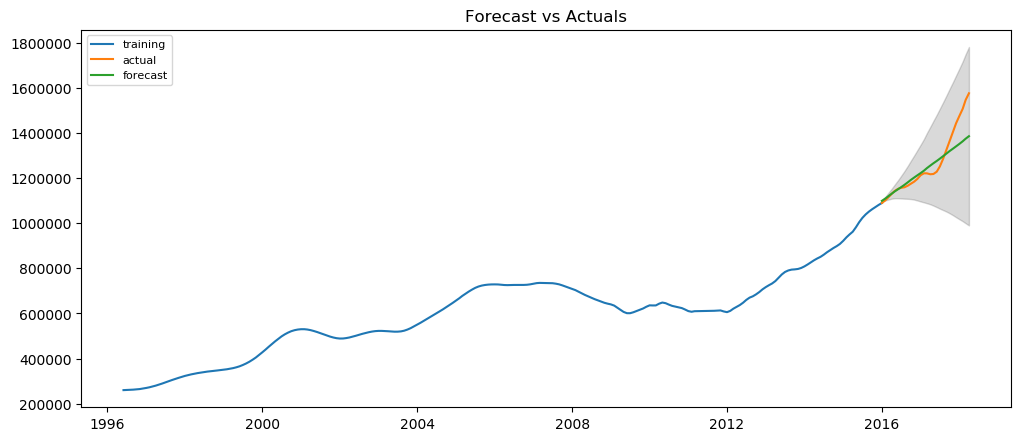

In [170]:
# Build Model
# model = ARIMA(train, order=(p,q,d))  
model = ARIMA(train.values, order=best_cfg)  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Step 6:applying the model for out of sample predictions from 2018 to 2021:

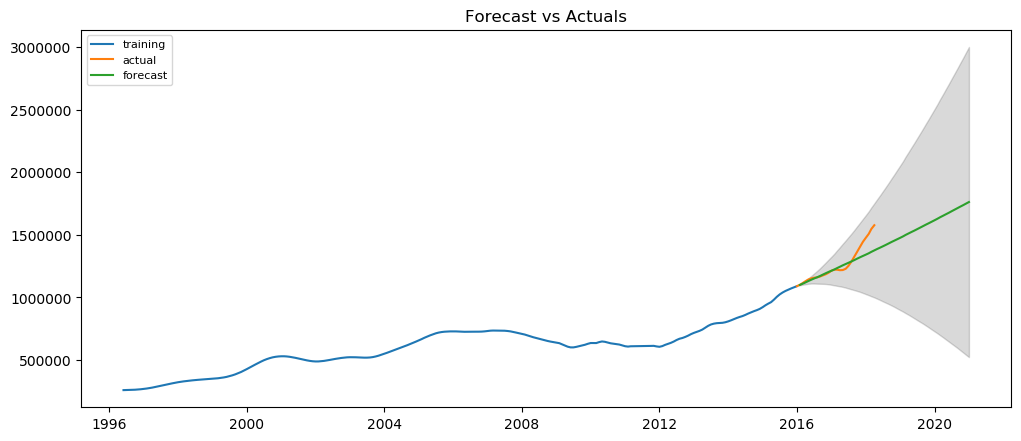

In [171]:
dates = pd.date_range('2016-01-01','2021-01-01',freq='M')
fc, se, conf = fitted.forecast(len(dates), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=dates)
lower_series = pd.Series(conf[:, 0], index=dates)
upper_series = pd.Series(conf[:, 1], index=dates)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# Step 7: Validating the model:

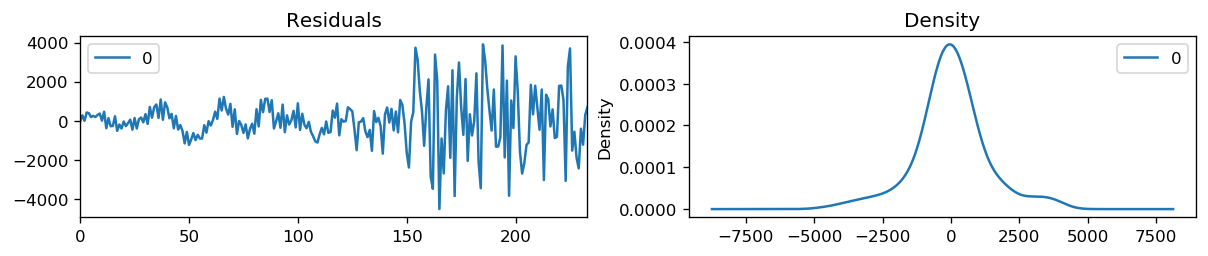

In [172]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Step 8: applying the model to all san jose metro area, CA, zip codes :

In [173]:
# Apply the model to all the zipcodes
zipcodes=data_sj.RegionName.unique()

profit_list = []
model_list = []
zipcode_list = []
purchase_list = []
sell_list = []

for zipcode in zipcodes:
       
    try:
        zip_df = data_sj.loc[(data_sj.RegionName==zipcode), ['value']].resample('MS').mean()
        
        #print(train)
        train_df = zip_df.loc['1996-06-01':'2016-01-01']
        test_df = zip_df.loc['2016-01-01':]
        model_df = ARIMA(train_df.values, order=best_cfg) 
        fitted_df = model_df.fit(disp=-1)
        
        dates = pd.date_range('2016-01-01','2021-01-01',freq='M')
        fc_df, se, conf = fitted_df.forecast(len(dates), alpha=0.05)  # 95% conf
        
        # Purchaseed during 2016
        purchase_value = zip_df['2016'].values.mean()
        
        # To be sold during 2020
        sell_value = fc_df[len(fc_df)-12:].mean()
        
        # Calculate the percentage of profit made from the investment
        profit = (sell_value - purchase_value)/purchase_value
        profit_list.append(profit)
        model_list.append(fitted_df)
        zipcode_list.append(zipcode)
        purchase_list.append(purchase_value)
        sell_list.append(sell_value)        
    except:
        continue



In [174]:
final_results = pd.DataFrame(data=list(zip(zipcode_list, profit_list, model_list,sell_list,purchase_list)), columns=['zipcode','profit','model','sell','purchase'])
final_results.sort_values(by='profit', ascending=False, inplace=True)
final_results.head(5)

,zipcode,profit,model,sell,purchase
7,95050,0.689942,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.668578e+06,9.873583e+05
24,94089,0.617839,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.458239e+06,9.013500e+05
21,95131,0.561827,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.393332e+06,8.921167e+05
29,95130,0.529279,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.825985e+06,1.194017e+06
2,95112,0.518737,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.030083e+06,6.782500e+05


# Step 9: visualizing predictions for top 5 zipcodes of san jose metro area:

Zip Code: 95050


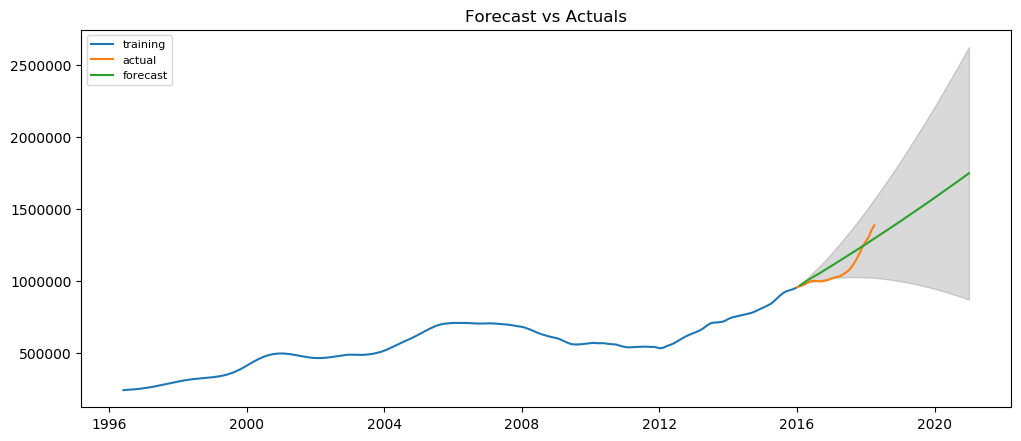

Zip Code: 94089


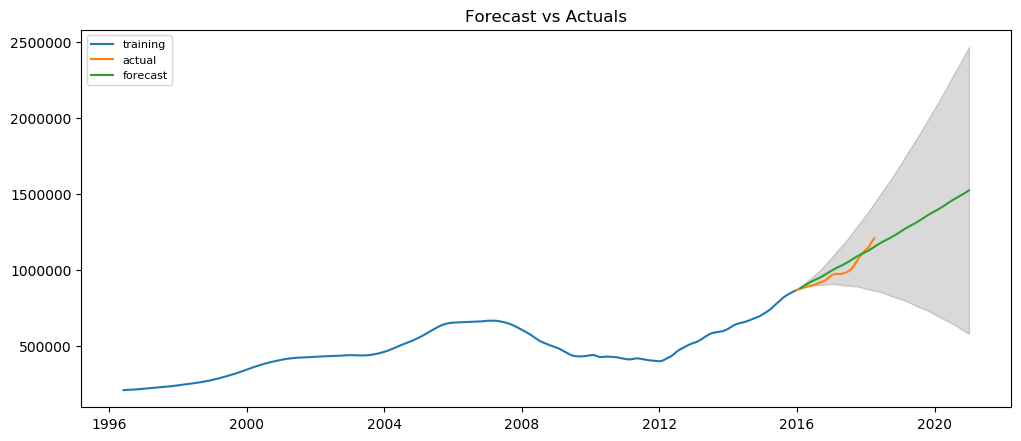

Zip Code: 95131


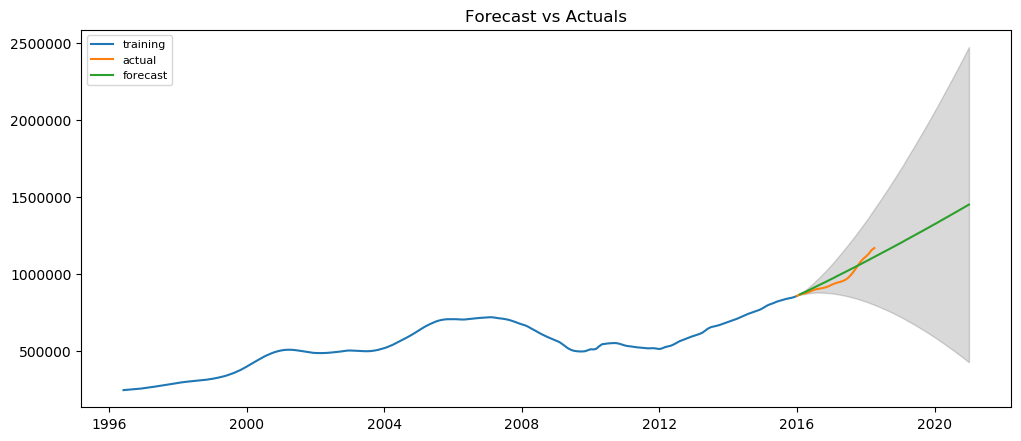

Zip Code: 95130


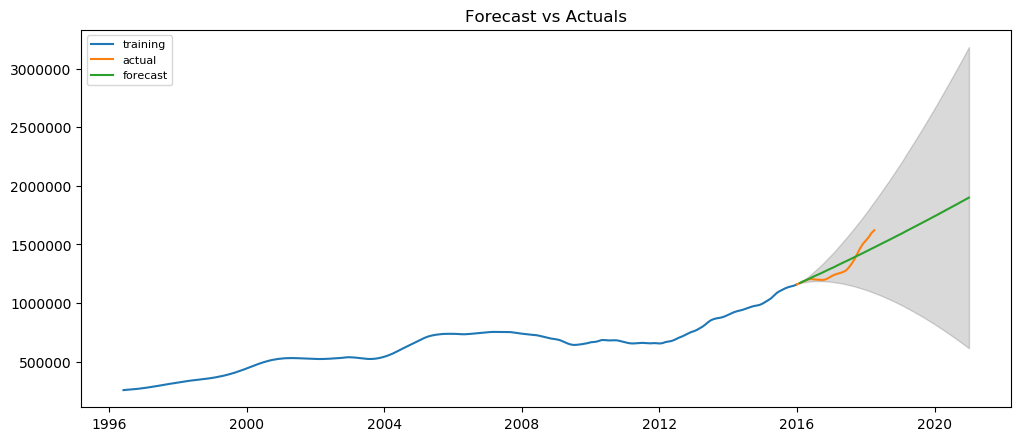

Zip Code: 95112


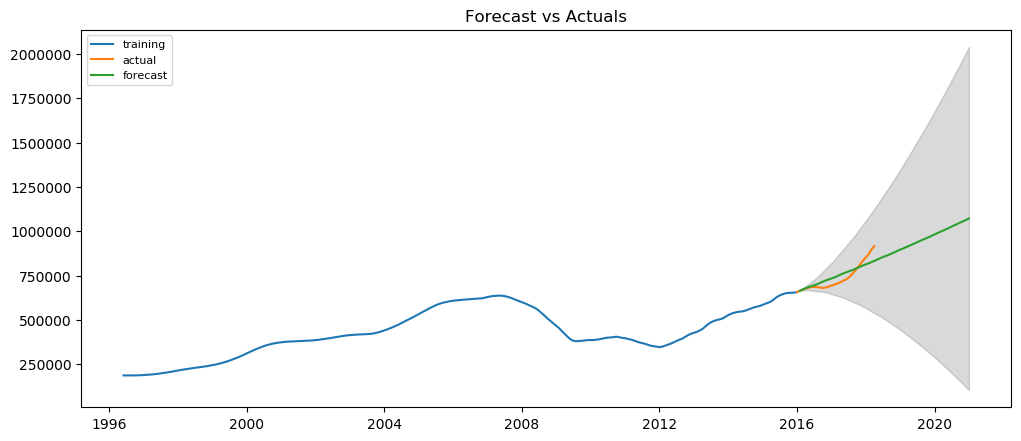

In [175]:
def plot_predictions(pred_model,train_df,test_df):
    dates = pd.date_range('2016-01-01','2021-01-01',freq='M')
    fc_df, se_df, conf_df = pred_model.forecast(len(dates), alpha=0.05)  # 95% conf
    
    # Make as pandas series
    fc_series_df = pd.Series(fc_df, index=dates)
    lower_series_df = pd.Series(conf_df[:, 0], index=dates)
    upper_series_df = pd.Series(conf_df[:, 1], index=dates)
    
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train_df, label='training')
    plt.plot(test_df, label='actual')
    plt.plot(fc_series_df, label='forecast')
    plt.fill_between(lower_series_df.index, lower_series_df, upper_series_df, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


for index, row in final_results.head(5).iterrows():
    zip_df = data_sj.loc[(data_sj.RegionName==row["zipcode"]), ['value']].resample('MS').mean()
    print(f'Zip Code: {row["zipcode"]}')
    train_df = zip_df.loc['1996-06-01':'2016-01-01']
    test_df = zip_df.loc['2016-01-01':]
    plot_predictions(row["model"],train_df,test_df)
